<a href="https://colab.research.google.com/github/dddonghwa/IAB/blob/main/hw4_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 과제 1 답안

### 실험 결과 설명

Convolution Layer을 2개 쌓기 위해서는 `kernel_size = 5, padding = 0`이 가능할 것이라고 생각했습니다.   
따라서 이 두 개 인자의 값은 고정하고 filter depth의 경우에 기존에 제시되었던 6에 대한 배수들을 적용해보았습니다.   
다음은 여러 가지 경우의 수에 대한 실험 결과입니다. 

\* conv 구조 열의 데이터는 nn.Conv2d에 들어가는 파라미터(`in_channels`, `out_channels`, `kernel_size`)를 의미합니다.

|conv1 구조| conv2 구조| final loss| test 정답률 |
|:-:|:-:|:-:|:-:|
|(3, 6, 5)|(6, 6, 5)|2.3|52%|
|(3, 6, 5)|(6, 12, 5)|1.319| 54%|
|(3, 6, 5)|(6, 48, 5)|1.176|57%|
|(3, 12, 5)|(12, 48, 5)|1.135|62%|

다음는 best model에 대한 코드 수행 결과입니다.



In [ ]:

import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 12, 5)
    self.conv2 = nn.Conv2d(12, 48, 5)

    self.pool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()

    self.fc1 = nn.Linear(5*5*48, 10)
  
  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = torch.flatten(x, 1)

    x = self.fc1(x)

    return x

net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)  # Learning rate: 학습률. 한 번의 optimizer step에서 얼마나 멀리 갈지. 

In [ ]:
training_loss_history = []
test_loss_history = []

for epoch in range(2):  # 전체 데이터셋을 몇 번 반복할 건지

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # 2000 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))

            training_loss_history.append(running_loss / 200)
            
            with torch.no_grad():
                running_test_loss = 0.0
                for i, test_data in enumerate(testloader, 0):
                    test_images, test_labels = test_data
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs, test_labels)
                    running_test_loss += test_loss.item()
                
                test_loss_history.append(running_test_loss / i)
                    
            running_loss = 0.0
                    
print('학습 끝!')

[1,   200] loss: 2.065
[1,   400] loss: 1.789
[1,   600] loss: 1.617
[1,   800] loss: 1.564
[1,  1000] loss: 1.482
[1,  1200] loss: 1.459
[1,  1400] loss: 1.390
[1,  1600] loss: 1.364
[1,  1800] loss: 1.346
[1,  2000] loss: 1.337
[1,  2200] loss: 1.294
[1,  2400] loss: 1.291
[1,  2600] loss: 1.262
[1,  2800] loss: 1.237
[1,  3000] loss: 1.231
[2,   200] loss: 1.130
[2,   400] loss: 1.116
[2,   600] loss: 1.172
[2,   800] loss: 1.152
[2,  1000] loss: 1.147
[2,  1200] loss: 1.092
[2,  1400] loss: 1.132
[2,  1600] loss: 1.170
[2,  1800] loss: 1.164
[2,  2000] loss: 1.114
[2,  2200] loss: 1.134
[2,  2400] loss: 1.131
[2,  2600] loss: 1.103
[2,  2800] loss: 1.067
[2,  3000] loss: 1.135
학습 끝!


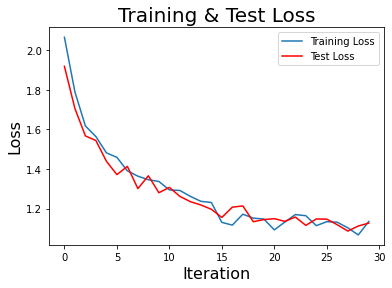

In [ ]:
plt.plot(training_loss_history, label="Training Loss") 
plt.plot(test_loss_history, 'r', label="Test Loss") 
plt.title('Training & Test Loss', fontsize=20) 
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

In [ ]:
# 모델 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
# 모델 불러오기
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개의 테스트 이미지에 대한 정답률: %d %%' % (
    100 * correct / total))

10000개의 테스트 이미지에 대한 정답률: 62 %


## 과제 2 답안

학습률이란 모델이 optimizer가 계산한 방향으로 얼마나 큰 보폭으로 이동할 것인가 지표입니다.  
이 값이 너무 크면 손실함수가 최소가 되는 지점을 넘어가서 loss가 큰 폭으로 요동치고 결국 최소점을 못찾아가게 됩니다.(figure의 맨 왼쪽 그래프)  
반대로 값이 너무 작으면 주어진 iteration 안에 최소점을 찾지 못해서 이 역시 최소점을 찾아가지 못하게 됩니다. (figure의 맨 오른쪽 그래프)  
따라서 적절한 학습률을 찾는 것이 중요한데, 현재의 모델에서는 0.001~0.01 사이의 값이 가장 좋을 것으로 예상됩니다. 






[1,   500] loss: 2.281
[1,  1000] loss: 2.199
[1,  1500] loss: 2.168
[1,  2000] loss: 2.134
[1,  2500] loss: 2.170
[1,  3000] loss: 2.140
[2,   500] loss: 2.276
[2,  1000] loss: 2.316
[2,  1500] loss: 2.192
[2,  2000] loss: 2.113
[2,  2500] loss: 2.092
[2,  3000] loss: 2.098
learning_rate = 0.1 학습 끝!
[1,   500] loss: 1.840
[1,  1000] loss: 1.544
[1,  1500] loss: 1.445
[1,  2000] loss: 1.394
[1,  2500] loss: 1.365
[1,  3000] loss: 1.351
[2,   500] loss: 1.247
[2,  1000] loss: 1.254
[2,  1500] loss: 1.245
[2,  2000] loss: 1.243
[2,  2500] loss: 1.260
[2,  3000] loss: 1.246
learning_rate = 0.01 학습 끝!
[1,   500] loss: 2.094
[1,  1000] loss: 1.831
[1,  1500] loss: 1.682
[1,  2000] loss: 1.582
[1,  2500] loss: 1.521
[1,  3000] loss: 1.478
[2,   500] loss: 1.408
[2,  1000] loss: 1.375
[2,  1500] loss: 1.336
[2,  2000] loss: 1.322
[2,  2500] loss: 1.305
[2,  3000] loss: 1.262
learning_rate = 0.001 학습 끝!
[1,   500] loss: 2.292
[1,  1000] loss: 2.252
[1,  1500] loss: 2.173
[1,  2000] loss: 2.087

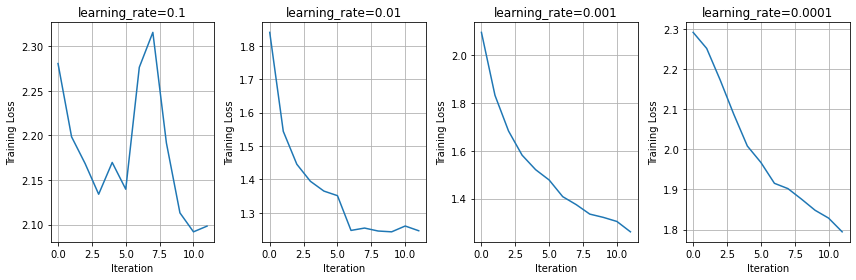

In [ ]:
import torch.optim as optim

lr_list = [0.1, 0.01, 0.001, 0.0001]

fig, axes = plt.subplots(nrows=1, ncols=len(lr_list), figsize=(12,4))
for lr_idx, lr_val in enumerate(lr_list) :
  
      net = Net()
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.SGD(net.parameters(), lr=lr_val, momentum=0.9)

      training_loss_history = []

      for epoch in range(2):  # 전체 데이터셋을 몇 번 반복할 건지
          running_loss = 0.0
          for i, data in enumerate(trainloader, 0):
              inputs, labels = data
              optimizer.zero_grad()
              outputs = net(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()
              if i % 500 == 499:    # 2000 미니배치마다 출력
                  print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))

                  training_loss_history.append(running_loss / 500)       
                  running_loss = 0.0
                          
      print(f'learning_rate = {lr_val} 학습 끝!')
      ax = axes[lr_idx]
      ax.plot(training_loss_history) 
      ax.set_title(f'learning_rate={lr_val}')  
      ax.set_xlabel('Iteration')
      ax.set_ylabel('Training Loss')
      ax.grid()

plt.tight_layout()      

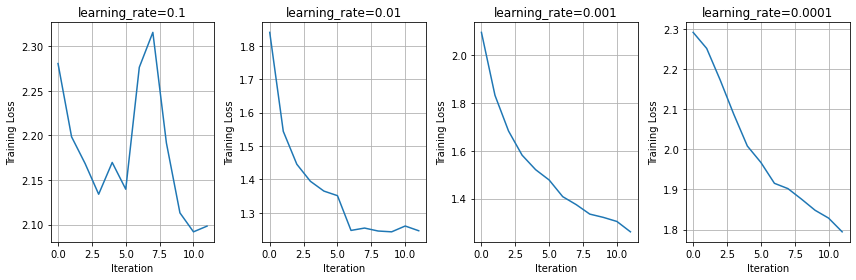

In [ ]:
fig.savefig("learning_rate.png")
fig